<a href="https://colab.research.google.com/github/manjunath6602/Major-code/blob/main/Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve

import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42)
tf.random.set_seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Update this path to match your file location in Drive
file_path = "/content/drive/My Drive/DATASET-balanced.csv"

# Load the CSV
df = pd.read_csv(file_path)

# Show first few rows
df.head()


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


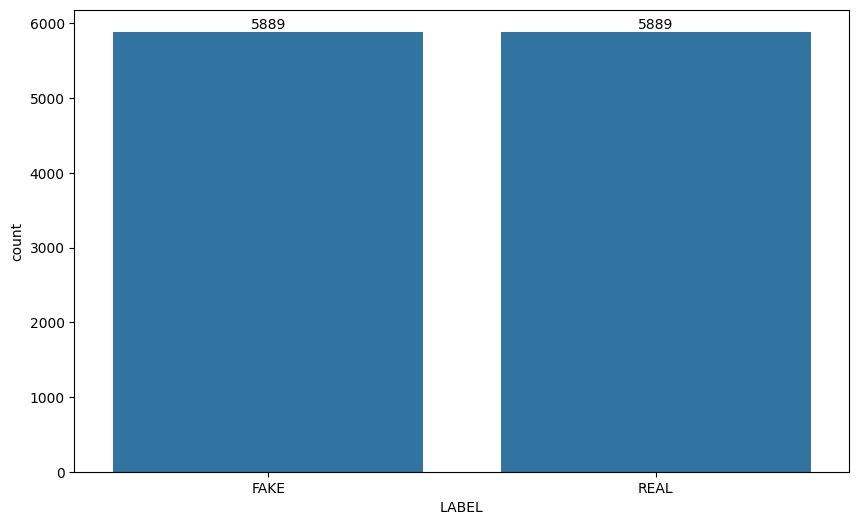

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='LABEL')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, int(p.get_height()),
             ha='center', va='bottom')

plt.show()

In [ ]:
label_encoder = LabelEncoder()
df['LABEL'] = label_encoder.fit_transform(df['LABEL'])

In [ ]:
y = df['LABEL']
X = df.drop('LABEL', axis = 1)

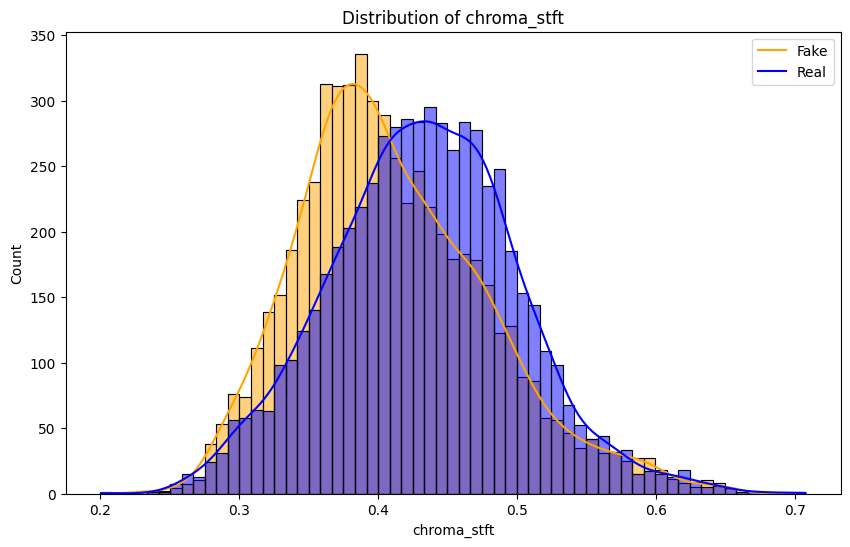

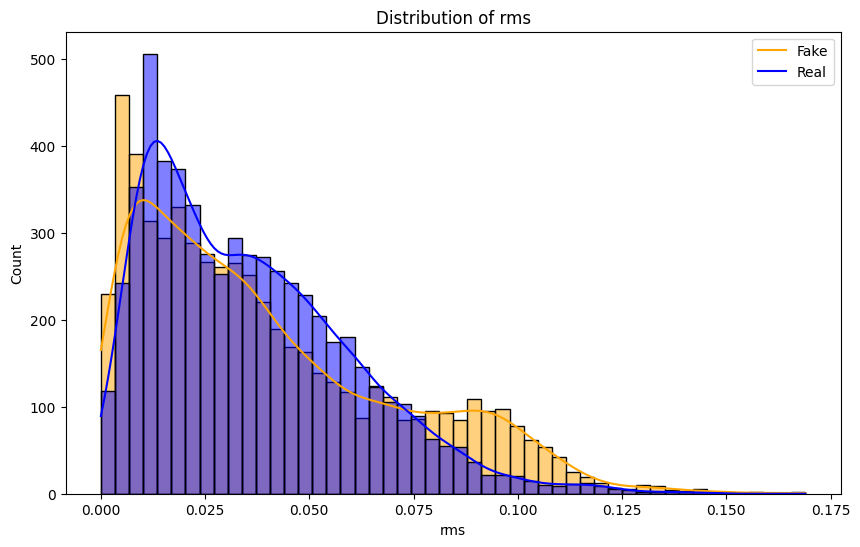

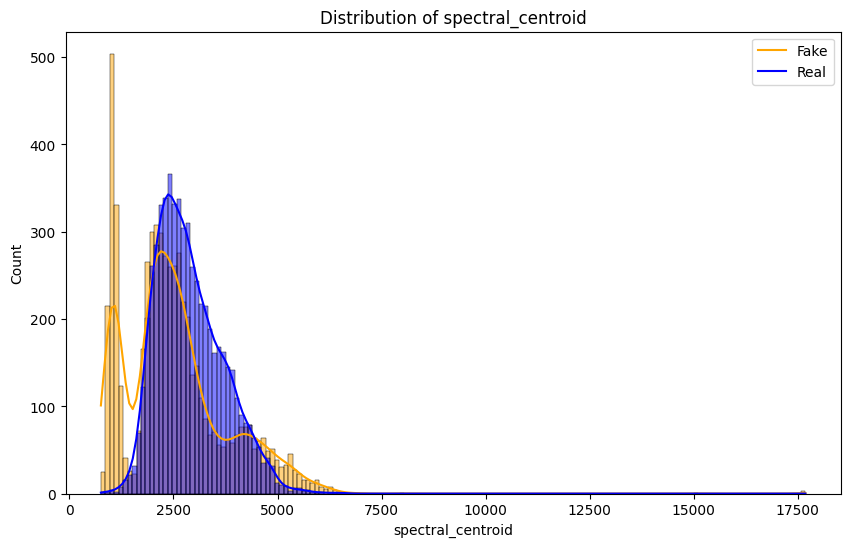

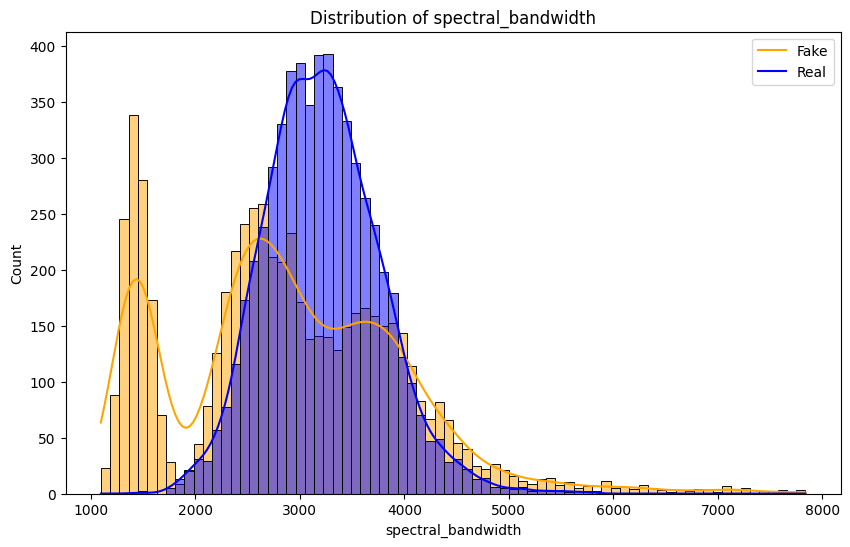

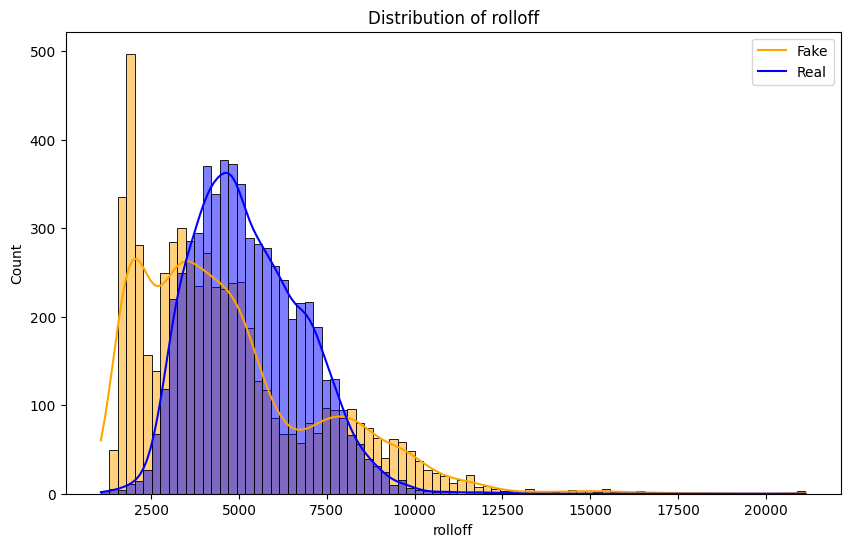

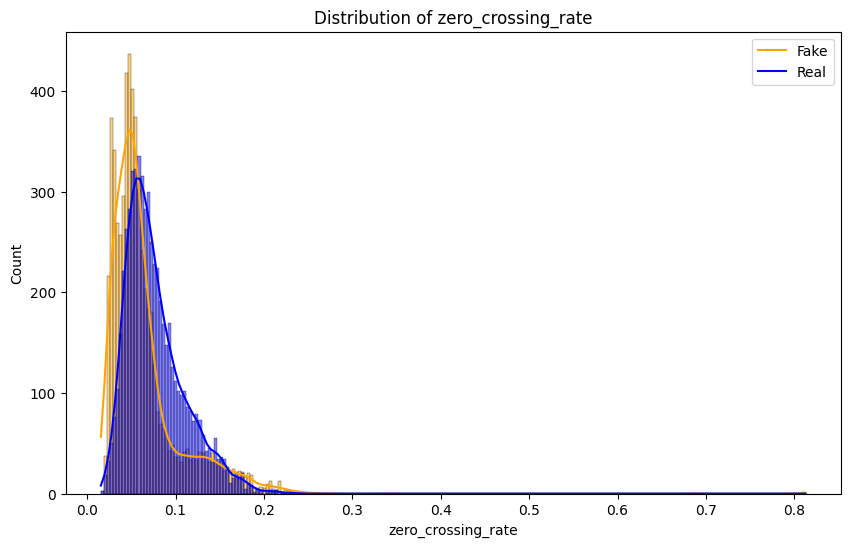

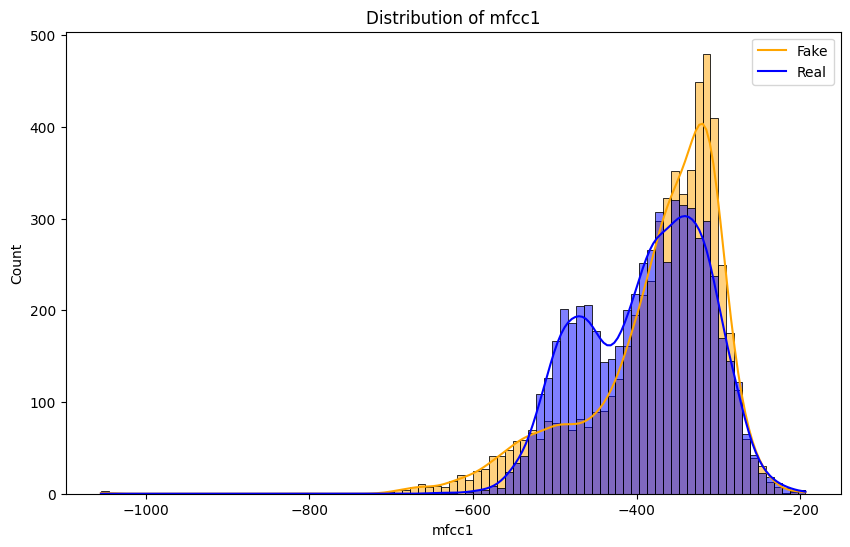

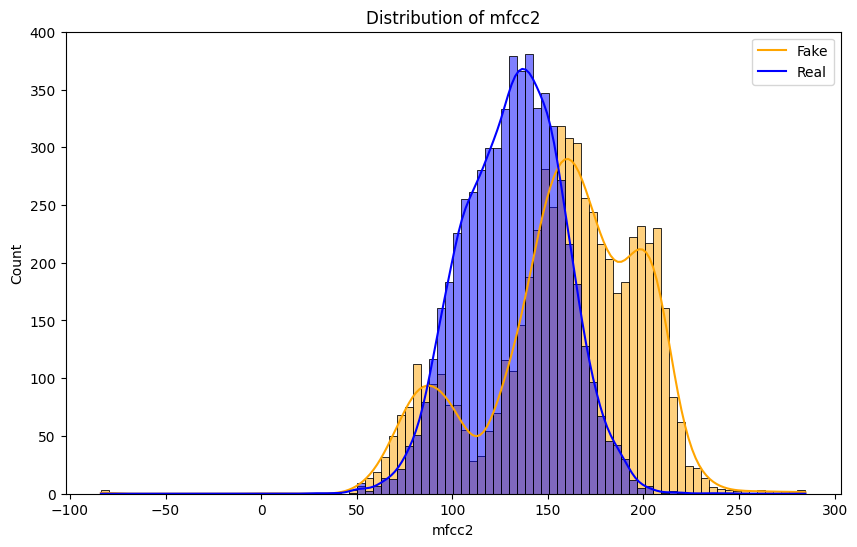

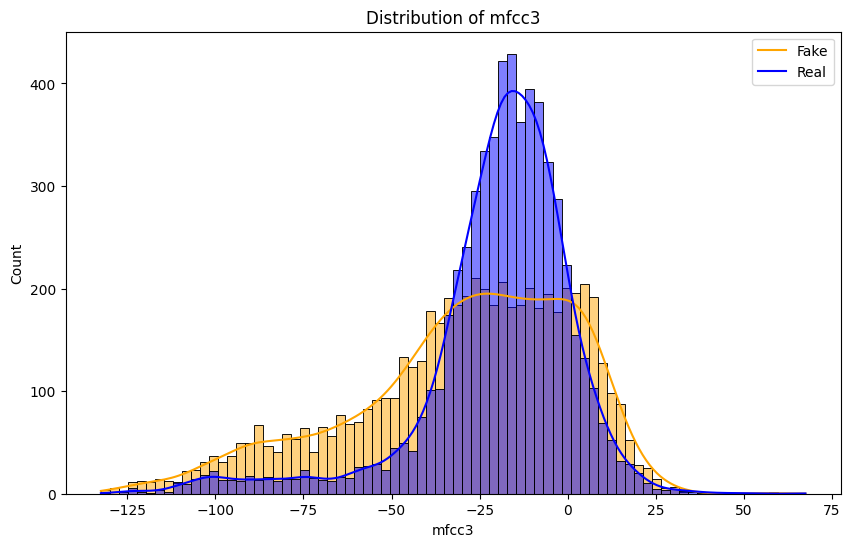

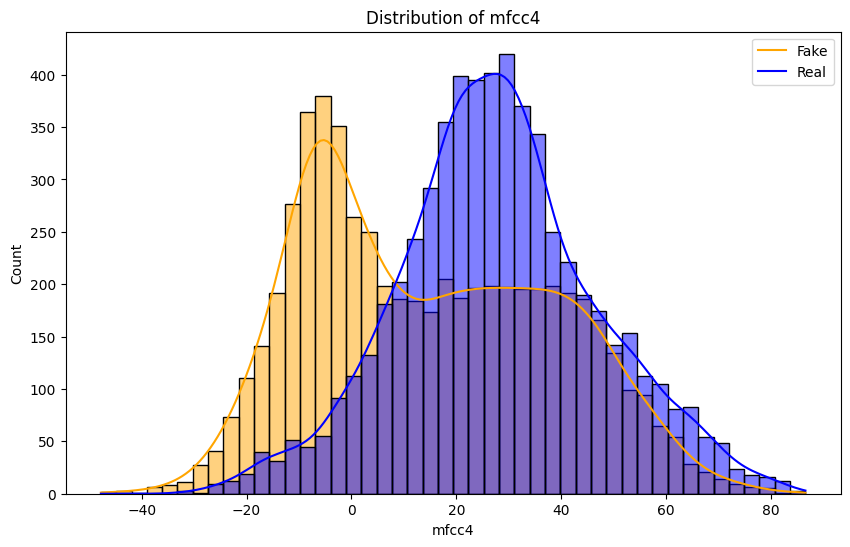

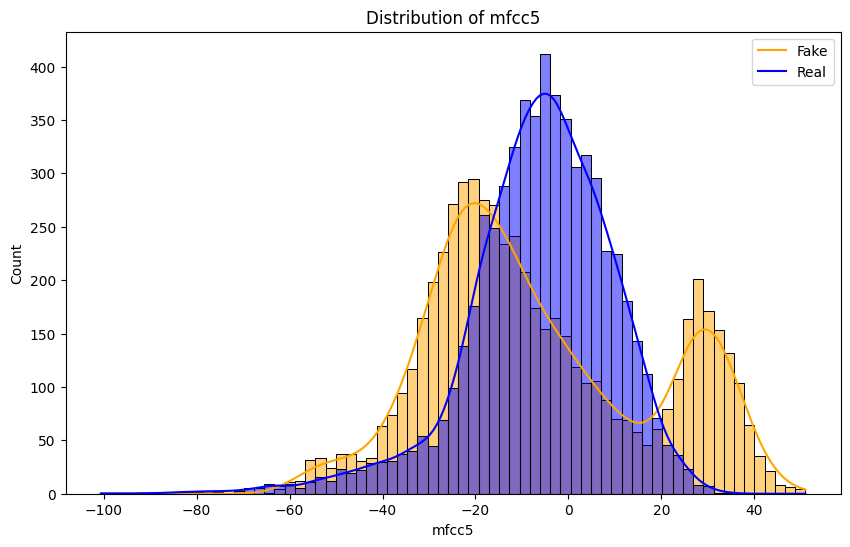

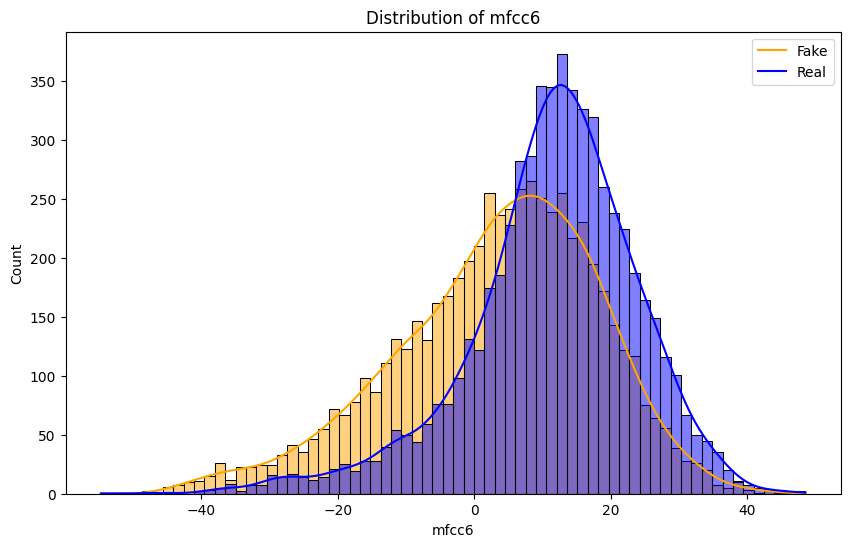

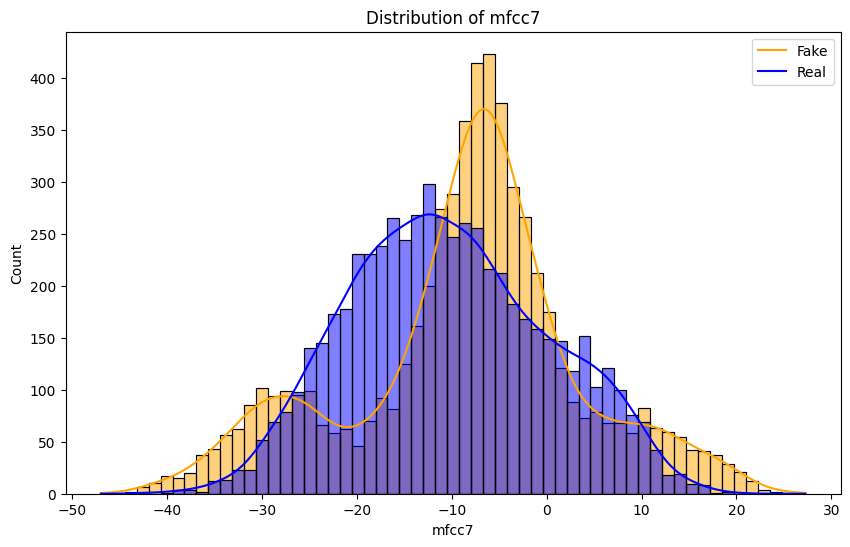

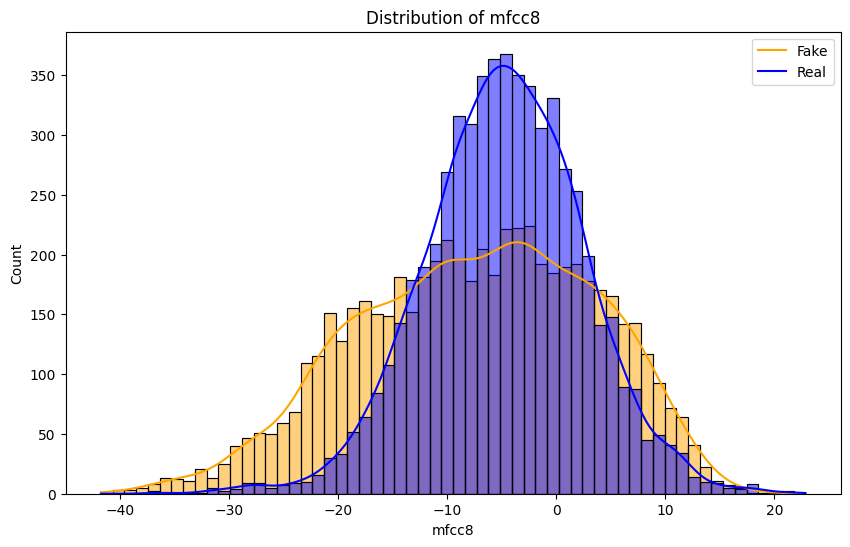

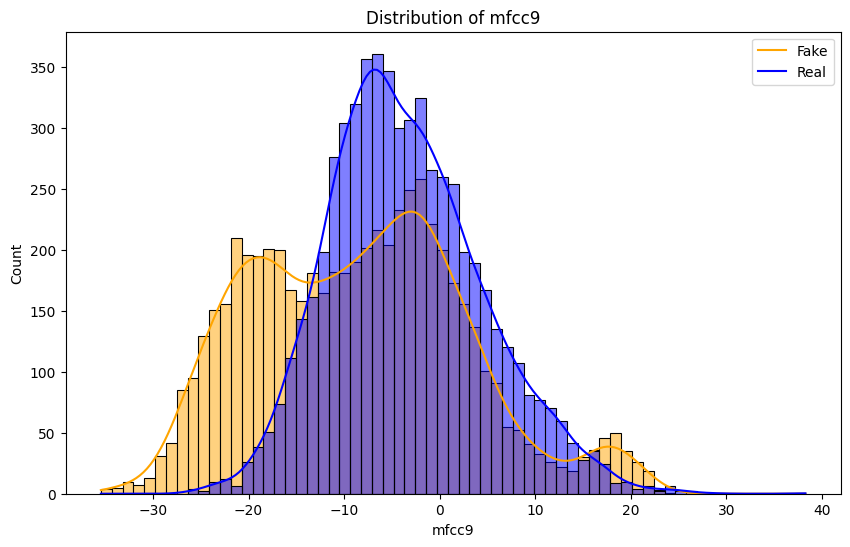

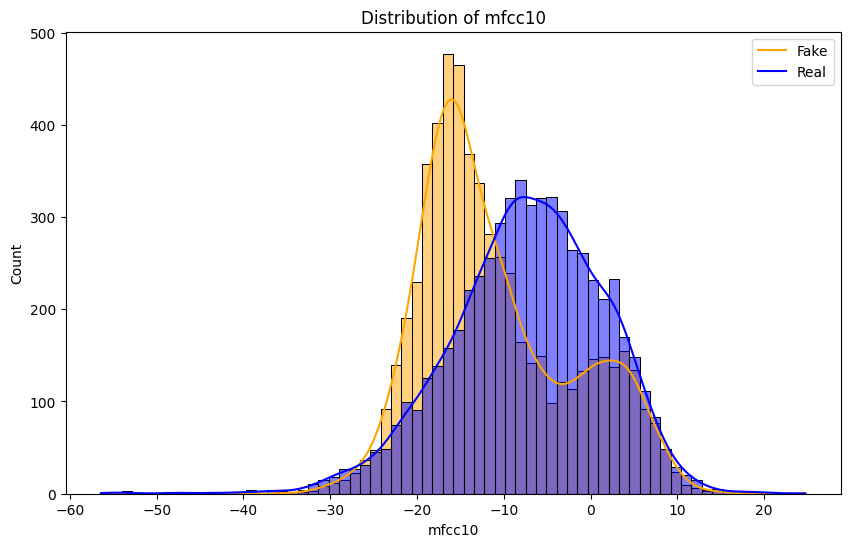

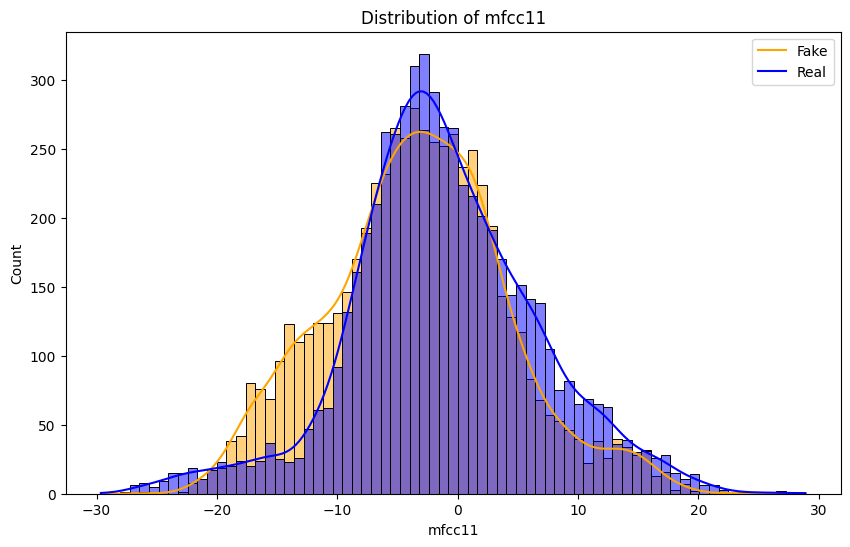

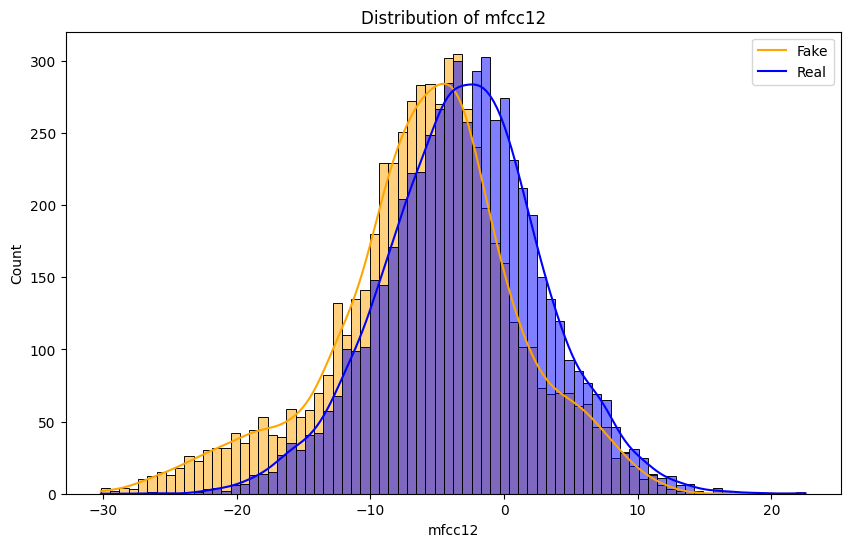

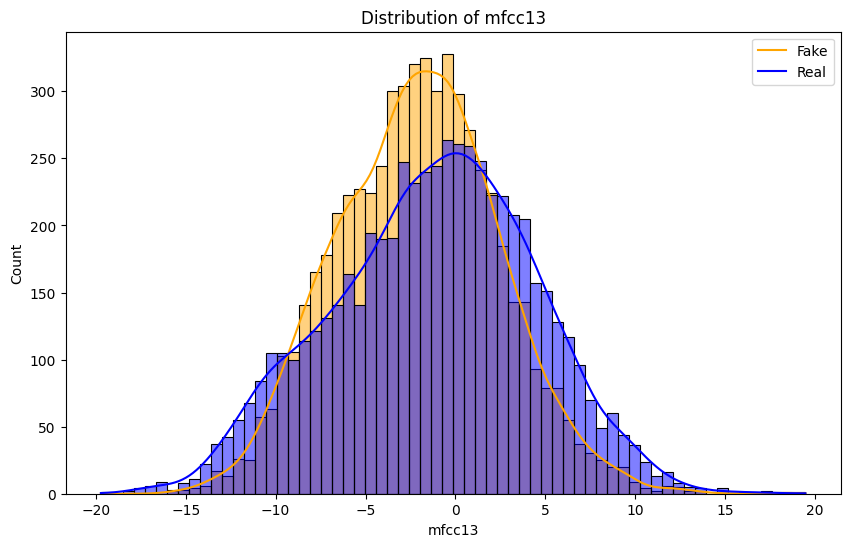

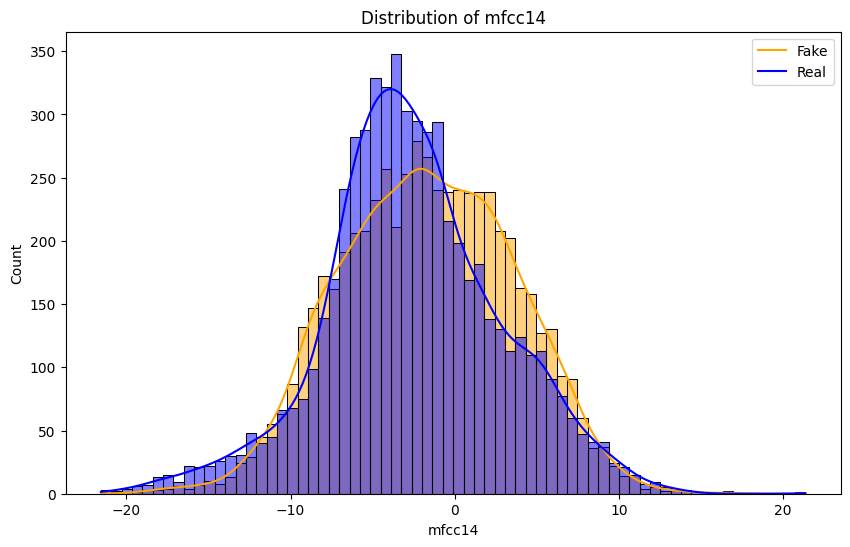

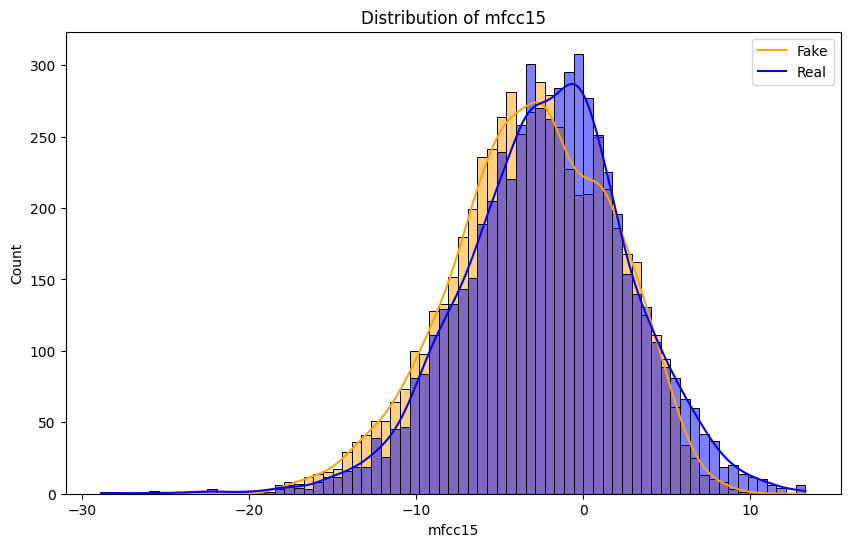

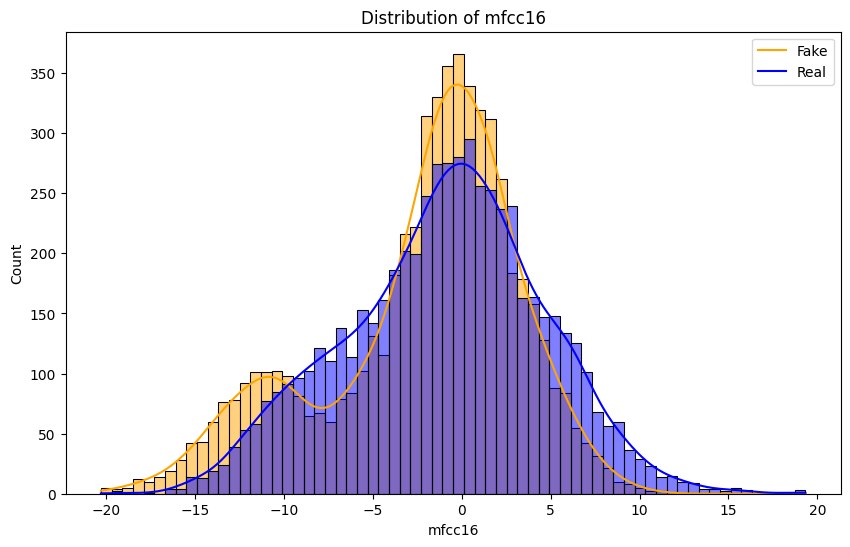

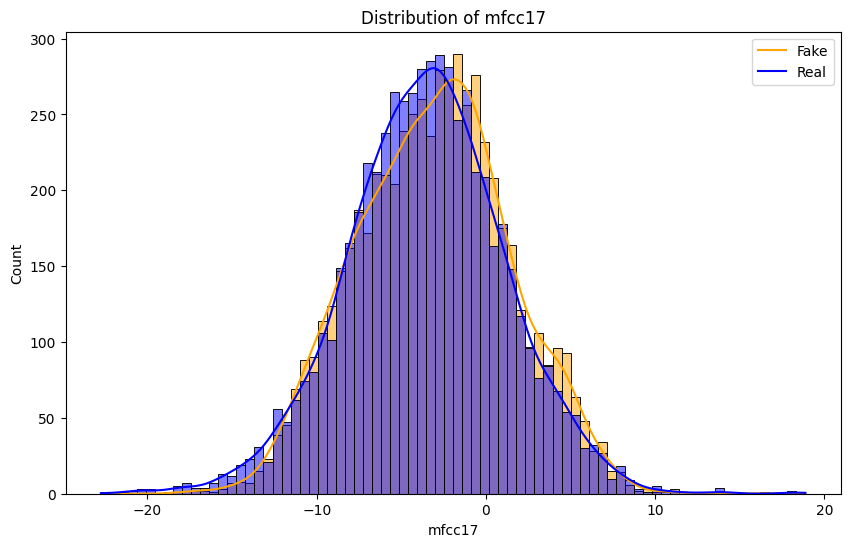

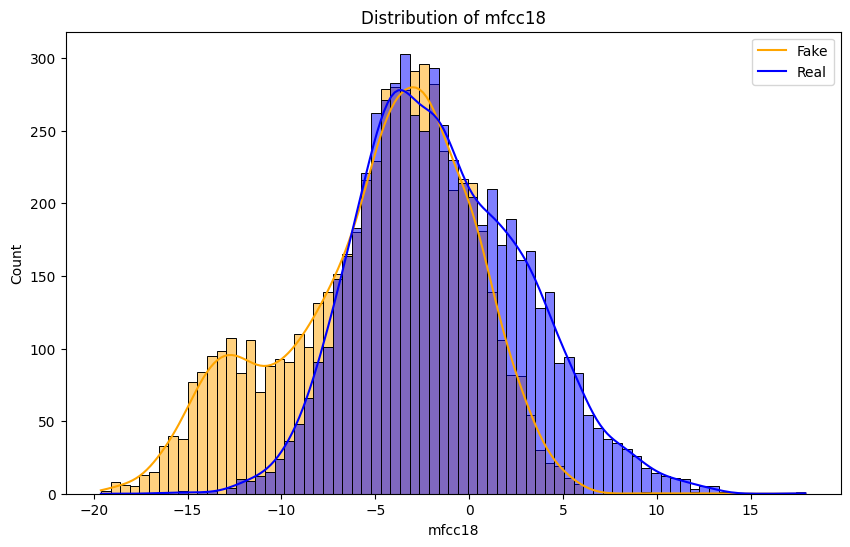

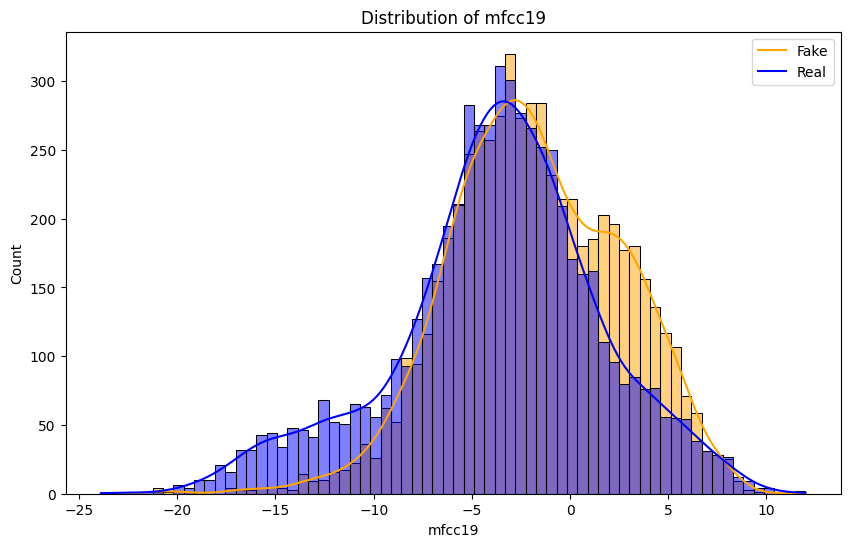

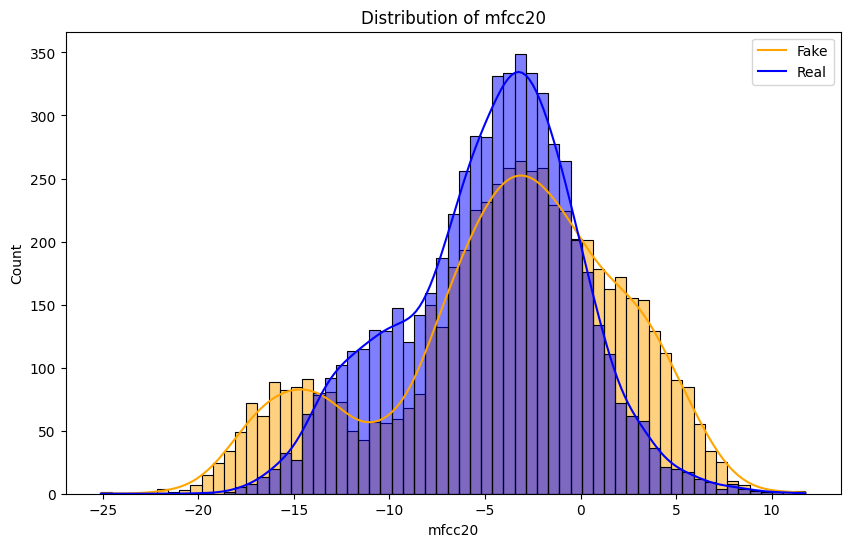

In [ ]:
for column in X:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue='LABEL', kde=True, palette=['blue', 'orange'])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(labels=['Fake', 'Real'])
    plt.show()

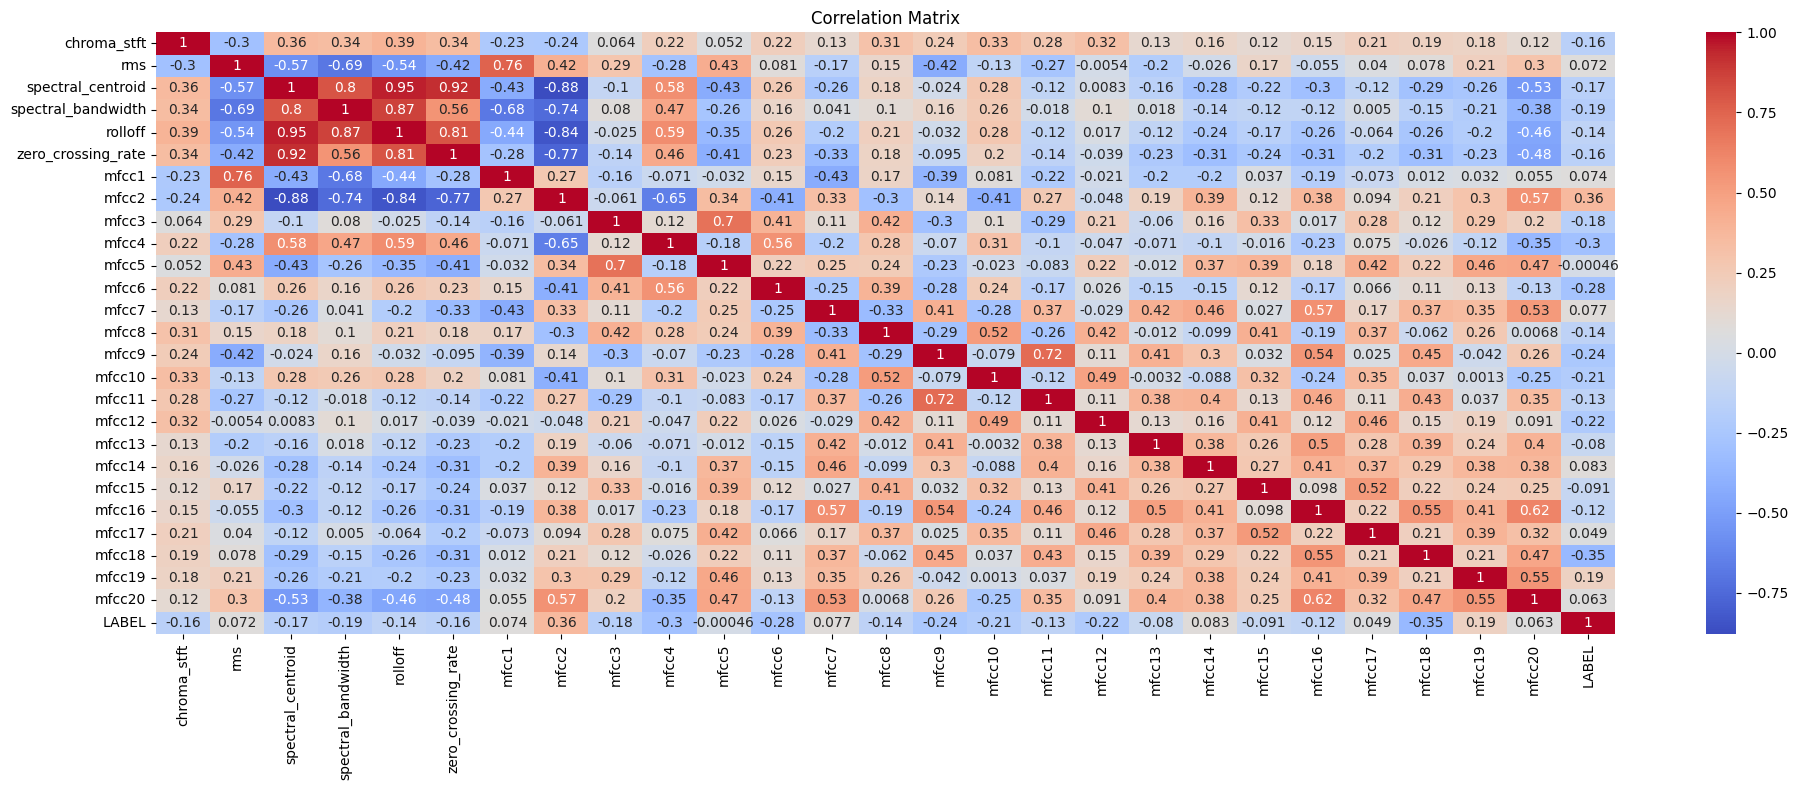

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [ ]:
def prepare_data(X, window_size = 10):

    data = []

    for i in range(len(X)):
        row = X.iloc[i].values
        row_data = []
        for j in range(len(row) - window_size):
            window = row[j : j + window_size]
            row_data.append(window)
        data.append(row_data)

    return np.array(data)

In [ ]:
X.iloc[:, :] = MinMaxScaler().fit_transform(X)
new_X = prepare_data(X, window_size = 5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y.values, test_size=0.2, shuffle = True, stratify = y.values, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state=42)

In [ ]:
model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss = BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 21, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,057 (207.25 KB)

 Trainable params: 53,057 (207.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = [
    ModelCheckpoint(filepath='model.keras'),
]

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data = (X_val, y_val), callbacks = callback)

Epoch 1/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5031 - loss: 0.6942 - val_accuracy: 0.5045 - val_loss: 0.6845
Epoch 2/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5508 - loss: 0.6838 - val_accuracy: 0.5963 - val_loss: 0.6480
Epoch 3/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6446 - loss: 0.6327 - val_accuracy: 0.7088 - val_loss: 0.5545
Epoch 4/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7208 - loss: 0.5580 - val_accuracy: 0.7475 - val_loss: 0.4980
Epoch 5/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7652 - loss: 0.4863 - val_accuracy: 0.7894 - val_loss: 0.4130
Epoch 6/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8074 - loss: 0.4019 - val_accuracy: 0.8297 - val_loss: 0.3626
Epoch 7/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8269 - loss: 0.3658 - val_accuracy: 0.8398 - val_loss: 0.3548
Epoch 8/60
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8389 - loss: 0.3483 - val_accu

In [ ]:
model = load_model('model.keras')


In [ ]:
%%time
y_pred = np.round(model.predict(X_test).flatten())

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
CPU times: user 915 ms, sys: 38.8 ms, total: 954 ms
Wall time: 1.31 s


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [ ]:
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9762308998302207
F1 Score:  0.9760479041916168
Recall:  0.9685908319185059
Precision:  0.9836206896551725


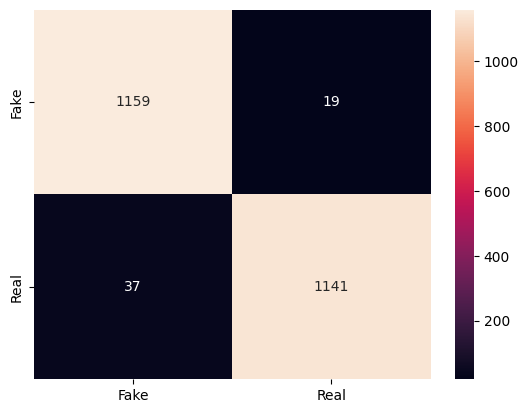

In [ ]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='.4g')
ax.xaxis.set_ticklabels(['Fake', 'Real'])
ax.yaxis.set_ticklabels(['Fake', 'Real'])
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

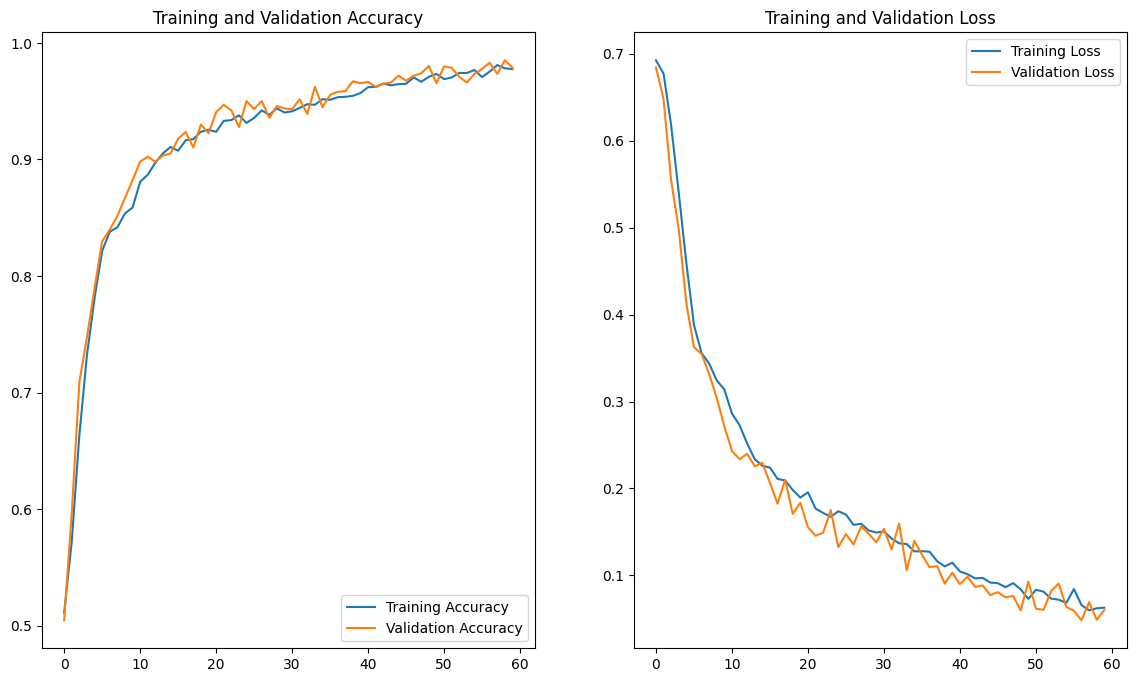

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
EPOCHS = len(acc)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter1d

sacc = gaussian_filter1d(acc, sigma=2)
sval_acc = gaussian_filter1d(val_acc, sigma=2)

sloss = gaussian_filter1d(loss, sigma=2)
sval_loss = gaussian_filter1d(val_loss, sigma=2)

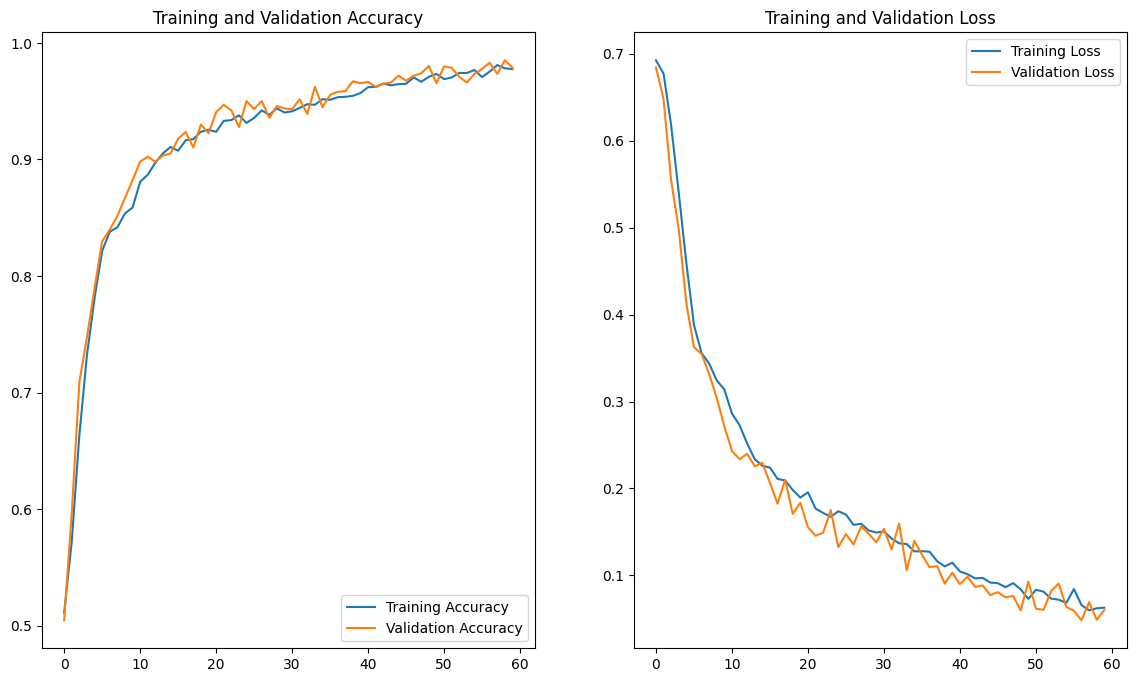

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
EPOCHS = len(acc)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()